In [1]:
! if [ ! -e rmf_tool ]; then git clone https://github.com/ngast/rmf_tool.git; fi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import rmf_tool.src.heterogeneous_rmf_tool as hrmf
np.random.seed(1) # to ensure reproducibility 

%matplotlib notebook

## Heterogeneous SIS Model Setup for HetPP class (heterogeneus unilateral transitions)

SIS model with N item and d = 2 dimensions (susceptible and infected). 

Transitions are defined specifying the tensors 'unilateral_transitions' and 'pairwise_transitions'. 

The recovery rate is chosen randomly between 0 and 1 implying that some individuals recover slower than others. 

In [3]:
N, d = 30, 2
S, I = 0, 1
model = hrmf.HetPP()

# initialization of rate tensors
A, B = np.zeros((N, d, d)), np.zeros((N, N, d, d, d, d)) 

# set unilateral transitions
# A[:, S, I] = np.ones((N))
A[:, S, I] = 0.1 * np.ones((N))
# introduce heterogeneity
np.random.seed(1)
A[:, I, S] = np.random.random((N))

# set pairwise transition rates
B[:, :, S, I, I, I] = (1/N) * np.ones((N, N))


# add rate tensor to the model and set initial state of the system
model.add_rate_tensors(A, B)
model.set_initial_state(np.ones((N,d))*np.array([1,0]))

### Mean field (X_trans) and refinement (V_trans) calculation

In [4]:
T_trans, X_trans ,V_trans, XVW_trans = model.meanFieldExpansionTransient(order=1, time=4)

### Sample mean calculation might take time

In [5]:
# calculate the sample mean of 200 trajectories
samples = 200

# to ensure reproducibility seeds can be set for the methods sampleMean, sampleMeanVariance, simulate
# seeds = np.arange(0,samples)

T_mean, X_mean, Err = model.sampleMeanVariance(time=4, samples=samples)

Mean Calculation; Nr. Simulations done:
10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  
Variance; Nr. Simulations done:
10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  

In [6]:
def plot_var_single(T, X, Var, i, s):
    plt.fill_between(T, X[:, i, s] + Var[:, i, s], X[:, i, s] - Var[:, i, s], color="cornflowerblue", alpha=.3)

### Plot of expected state of item i against its mean field approximation

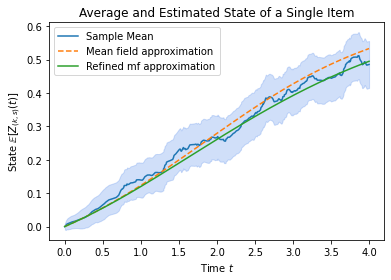

In [7]:
%matplotlib inline

sample_Var = 2* np.sqrt(Err)/np.sqrt(samples)

f = plt.figure()


i = 10
s = 1

plt.plot(T_mean, X_mean[:,i,s], label="Sample Mean")
plot_var_single(T_mean, X_mean, sample_Var, i, s)

plt.plot(T_trans, X_trans[:,i,s],'--', label="Mean field approximation")
plt.plot(T_trans,(X_trans + V_trans)[:,i,s], label="Refined mf approximation")


plt.legend()

plt.title(r"Average and Estimated State of a Single Item")
plt.xlabel('Time $t$')
plt.ylabel('State $\mathbb{E}[Z_{(k,s)}(t)]$')
plt.show()

### Density Dependent Representation

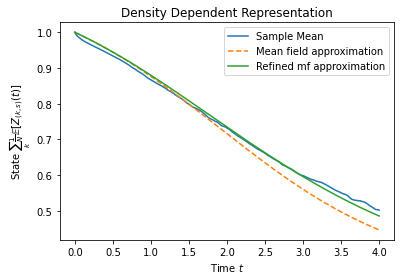

In [8]:
%matplotlib inline

f = plt.figure()


# state to be plotted
s = 0

plt.plot(T_mean, np.sum(X_mean[:,:,s], axis=1)/N, label="Sample Mean ")

plt.plot(T_trans, np.sum(X_trans[:,:,s], axis=1)/N,'--', label="Mean field approximation")
plt.plot(T_trans, np.sum((X_trans + V_trans)[:,:,s], axis=1)/N, label="Refined mf approximation")


plt.legend()

plt.title(r"Density Dependent Representation")
plt.xlabel('Time $t$')
plt.ylabel(r'State $\sum_{k}\frac{1}{N}\mathbb{E}[Z_{(k,s)}(t)]$')
plt.savefig('SIS_het_rmf.pdf', bbox_inches='tight')
plt.show()